In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Parameters.Parameters_Isolation import *



In [2]:
nx = 3
nu = 1

# xdot = vertcat(-u*x[0]*x[1]/N_pop, u*x[0]*x[1]/N_pop - alpha*x[1])#, alpha*x[1])[:nx]
# hamiltonian = x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (-lbd[1])*alpha*x[1]
# hamiltonian = x[1]**2 + Wu*u**2 -lbd[0]*x[0]# + lbd[2]*x[0])


In [3]:
def RK4_Integrator(f, X, U, DT):
       print(U.shape)
       k1 = f(X, U)
       k2 = f(X + DT/2 * k1, U)
       k3 = f(X + DT/2 * k2, U)
       k4 = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       return X

In [4]:

x0 = [N_pop-I0, I0, 0]
M = 50

u = MX.sym('u')
x0 = MX.sym('x0', nx)
lbd0 = MX.sym('lbd0', nx)
s0 = vertcat(x0, lbd0)
sk = s0
s_plot = [s0]
lbd_plot = [lbd0]
x_plot = [x0]
for i in range(M):
    sk = RK4_Integrator(F, sk, u, DT)
    lbd_plot.append(sk[0:nx])

s_dot = Function('s_dot', [s0, u], [sk])
f = Function('f_lbd', [x0, lbd0, u], [sk[nx:], sk[nx:]])




(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


In [5]:
# "Lift" initial conditions
X0 = MX.sym('x0', nx)
lbd_0 = MX.sym('lbd_0', nx)
x0 = [N_pop-I0, I0, 0][:nx]
Sk = vertcat(X0, lbd_0)

w = [Sk]
lbw = [x0]
ubw = [x0]
w0 = [x0]
x_min = [0]*nx
x_max = [N_pop]*nx
lbd_min = [0]*nx
lbd_max = [100]*nx
s_min = x_min + lbd_min
s_max = x_max + lbd_max
Q = []
g = [X0 - x0]
lbg = [0]*nx
ubg = [0]*nx
U = []
lbu = []
ubu = []
U0 = []
u0 = u_max
traj_initial = True
# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    U   += [Uk]
    lbu += [u_min]
    ubu += [u_max]
    U0  += [u0]

    # Integrate till the end of the interval
    Sk_end = s_dot(Sk, Uk)
    
    # New NLP variable for state at end of interval
    if k < (N-1):
        Sk = MX.sym('S_' + str(k+1), 2*nx)
        w   += [Sk]
        lbw += s_min
        ubw += s_max
    # Add equality constraint
        g   += [Sk_end-Sk]
        lbg += [0]*2*nx
        ubg += [0]*2*nx


g+= [Sk[nx:]]

g = vertcat(*g)
w = vertcat(*w)
U = vertcat(*U)


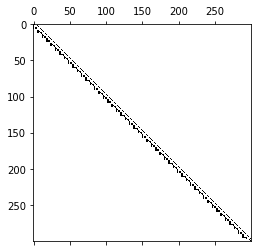

In [6]:
plt.spy(jacobian(g, w).sparsity())

In [7]:
from scipy.optimize import fsolve
uk = np.random.uniform(u_min, u_max, N)
f_r = Function('f_r', [w, U], [g])
grad_r = Function('grad_r', [w, U], [jacobian(f_r(w, U), w)])

opts = {}
opts['error_on_fail'] = False

G = rootfinder('G', 'newton', f_r, opts)


In [8]:
# w0 = np.random.uniform(1,2,w.shape)
# u0 = np.random.uniform(1,5,U.shape)
# a = grad_r(w0, u0)
#
# la.eig(a)[0] == 0

In [9]:
def Hamiltonian(x, lbd, u):
    return x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (lbd[1])*alpha*x[1]

def u_sol(x, lbd):
    u_opt = (lbd[1] - lbd[0])*x[0]*x[1]/(2*Wu)
    if u_opt < u_min:
        u_opt = u_min
    elif u_opt > u_max:
        u_opt = u_max
    return u_opt

def u_sol(x, lbd):
    u_opt = -lbd[1]*x[1]/(2*Wu)
    if u_opt < u_min:
        u_opt = DM(u_min)
    elif u_opt > u_max:
        u_opt = DM(u_max)
    return u_opt

In [16]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from Callbacks.Singleshoot import Singleshoot_CB

# lbd0 = np.random.uniform(0, N_pop*4, 2)
# x0 = np.random.uniform(0, N_pop*4, 2)

# Sk = np.concatenate([x0, lbd0])
Sk = DM([N_pop - I0, I0,0, 1, 2,3])
w0 = repmat(Sk, N)
tol = 1e-3
cond = tol + 1
U = []
lam_tol = 1e-3
lam_f = DM([1,1,1])
while norm_1(lam_f) > lam_tol:
    for k in range(N):
        U.append(u_sol(Sk[:nx], Sk[nx:]))
        Sk = s_dot(Sk, U[-1])
    tol = 1e-3
    wk = w0
    U = vertcat(*U)
    wk_sols = [w0]
    err = tol + 1
    errs = [err]
    while err > tol:
        fk = f_r(wk, U)
        wk = wk - la.inv(grad_r(wk, U)) @ fk
        err = norm_1(fk)
        errs.append(err)
    wk_sols.append(wk)
    Sk = wk[:Sk.shape[0]]
    lam_f = wk[-nx:]
    # w_sol = G(w0, vertcat(*U))

In [19]:
len(wk_sols)


DM([0, 0, 0])

In [20]:
x_sols = [[w_sol[0::nx*2],w_sol[1::nx*2],w_sol[2::nx*2]] for w_sol in wk_sols]
lbd_sols = [[w_sol[3::nx*2],w_sol[4::nx*2],w_sol[5::nx*2]] for w_sol in wk_sols]


Text(0.5, 1.0, '$\\lambda$-Multipliers')

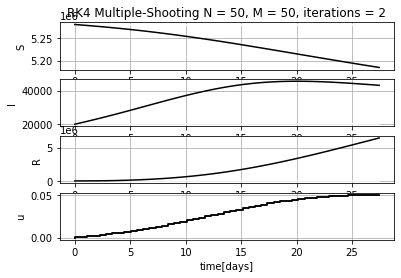

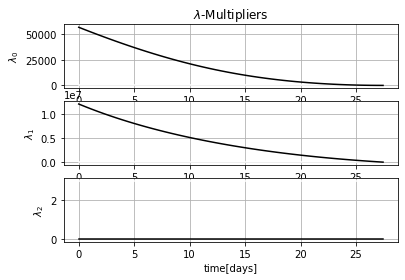

In [21]:

tgrid = np.arange(0,T, h)
import matplotlib.pyplot as plt
from matplotlib import cm
colormap = cm.get_cmap('Greys', len(x_sols))
colors = colormap(np.linspace(.1, .8, len(x_sols)))

fig1, ax1 = plt.subplots(4)
fig2, ax2 = plt.subplots(3)
for x_sol, lbd_sol, color in zip(x_sols, lbd_sols, colors):
    ax1[0].plot(tgrid, x_sol[0], color=color)
    ax1[1].plot(tgrid, x_sol[1], color = color)
    ax1[2].plot(tgrid, x_sol[2], color = color)
    ax1[3].step(tgrid, U, color='k')

    ax2[0].plot(tgrid, lbd_sol[0], color=color)
    ax2[1].plot(tgrid, lbd_sol[1], color = color)
    ax2[2].plot(tgrid, lbd_sol[2], color = color)

_ = [x.grid() for x in np.concatenate([ax1, ax2])]
ax1[0].set_title('RK4 Multiple-Shooting N = %i, ' %N+ "M = %i" %M+ ", iterations = %i" %len(x_sols))

_ = [x.set_ylabel(l) for l, x in zip(['S', 'I', 'R', 'u'], ax1)]
_ = [x.set_ylabel(l) for l, x in zip([r'$\lambda_0$',r'$\lambda_1$',r'$\lambda_2$'], ax2)]
_ = ax1[-1].set_xlabel('time[days]')
_ = ax2[-1].set_xlabel('time[days]')
ax2[0].set_title('$\lambda$-Multipliers')



In [13]:
# fig.savefig('../Figures/PMP_traj_' + sim_name + '.eps', format='eps')
# fig.savefig('../Figures/PMP_cons_' + sim_name + '.eps', format='eps')

NameError: name 'fig' is not defined